# imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from glob import glob as glob
from pathlib import Path

from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn  as sns

from sklearn.metrics import confusion_matrix, classification_report

# Getting Images

In [ ]:
processed_crackdir = Path("../data/processed/pro_crack_img")
processed_noncrackdir = Path("../data/processed/pro_noncrack_img")

# ogcrack_dir = Path("../data/external/Crack")
# ognoncrack_dir = Path("../data/external/Non-crack")

def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
crack_df = generate_df(processed_crackdir, label="CRACK_IMAGE")
noncrack_df = generate_df(processed_noncrackdir,label="NONCRACK_IMAGE")

# crack_df = generate_df(ogcrack_dir, label="CRACK_IMAGE")
# noncrack_df = generate_df(ognoncrack_dir,label="NONCRACK_IMAGE")

# crack_sample = crack_df.sample(n=10000, random_state=42)
# noncrack_sample = noncrack_df.sample(n=10000, random_state=42)

total_df = pd.concat([crack_df, noncrack_df], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

print(total_df.shape)

(20000, 2)


# Test-Train split

In [5]:
train_df, test_df = train_test_split(
    total_df.sample(8000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

train_df

,Filepath,Label
9760,..\data\external\Crack\05943.jpg,CRACK_IMAGE
442,..\data\external\Non-crack\19258.jpg,NONCRACK_IMAGE
596,..\data\external\Non-crack\07151.jpg,NONCRACK_IMAGE
11655,..\data\external\Non-crack\16964.jpg,NONCRACK_IMAGE
11944,..\data\external\Non-crack\01526.jpg,NONCRACK_IMAGE
...,...,...
2360,..\data\external\Crack\01366.jpg,CRACK_IMAGE
2694,..\data\external\Non-crack\17167.jpg,NONCRACK_IMAGE
18896,..\data\external\Non-crack\07697.jpg,NONCRACK_IMAGE
11749,..\data\external\Crack\03144.jpg,CRACK_IMAGE


# Loading/Adding Images

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                # rescale = 1./255,
                validation_split = 0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                # rescale = 1./255
)


In [7]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=20,
    shuffle=False,
    seed=42
)

Found 4480 validated image filenames belonging to 2 classes.
Found 1120 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.


# Training

In [8]:
inputs = tf.keras.Input(shape=(120, 120, 1))
x = tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 12)   │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,761 (10.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

c:\Users\saiprasath\ML-Surface-Crack-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 57s 242ms/step - accuracy: 0.5644 - loss: 0.6781 - val_accuracy: 0.5955 - val_loss: 0.6111
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.7245 - loss: 0.5810 - val_accuracy: 0.8714 - val_loss: 0.4683
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.8837 - loss: 0.4440 - val_accuracy: 0.9000 - val_loss: 0.3396
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.9190 - loss: 0.3217 - val_accuracy: 0.9232 - val_loss: 0.2519
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.9349 - loss: 0.2513 - val_accuracy: 0.9330 - val_loss: 0.2017
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9529 - loss: 0.1968 - val_accuracy: 0.9518 - val_loss: 0.1708
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9450 - loss: 0.2008 - val_accuracy: 0.9571 - val_loss: 0.1478
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9564 - loss: 

In [10]:
print(history.history.keys())

fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)
fig.show(renderer='browser')

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


c:\Users\saiprasath\ML-Surface-Crack-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



    Test Loss: 0.07203
Test Accuracy: 97.75%
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


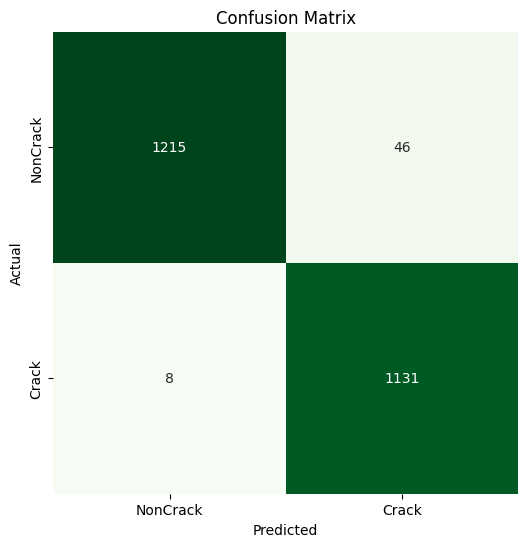

Classification Report:
----------------------
 {'Non-Crack': {'precision': 0.9934587080948487, 'recall': 0.9635210150674068, 'f1-score': 0.9782608695652174, 'support': 1261.0}, 'Crack': {'precision': 0.9609175870858114, 'recall': 0.9929762949956101, 'f1-score': 0.9766839378238342, 'support': 1139.0}, 'accuracy': 0.9775, 'macro avg': {'precision': 0.9771881475903301, 'recall': 0.9782486550315085, 'f1-score': 0.9774724036945258, 'support': 2400.0}, 'weighted avg': {'precision': 0.9780152344159764, 'recall': 0.9775, 'f1-score': 0.9775124840429527, 'support': 2400.0}}


In [11]:
results = model.evaluate(test_data, verbose=0)
loss = results[0]
acc = results[1]
    
print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))
    
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["Non-Crack", "Crack"],output_dict=True)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NonCrack", "Crack"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NonCrack", "Crack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
    
print("Classification Report:\n----------------------\n", clr)

# Logging Model to MLflow

In [12]:
import dagshub
dagshub.init(repo_owner='Saipr14', repo_name='ML-Surface-Crack-Detection', mlflow=True)

Accessing as Saipr14

Initialized MLflow to track repo "Saipr14/ML-Surface-Crack-Detection"

Repository Saipr14/ML-Surface-Crack-Detection initialized!

In [ ]:
import mlflow
import mlflow.keras

mlflow.set_experiment("Crack Detection Model")
mlflow.set_tracking_uri("https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow")

params = {
    "optimizer": "adam",
    "loss_function": "binary_crossentropy",
    "metrics": "accuracy", 
    "batch_size": 20, 
    "epochs": 37  
}

with mlflow.start_run(run_name="Processed-image CNN model"):
    mlflow.log_params(params)
    mlflow.log_metrics({
        'accuracy': clr['accuracy'],
        'precision': clr['Crack']['precision'],  # Get precision for 'Crack' class
        'recall': clr['Crack']['recall'],  # Get recall for 'Crack' class
        'f1-score': clr['Crack']['f1-score']  # Get F1-score for 'Crack' class
    })


    mlflow.keras.log_model(model, "Crack_Detection_Model")

    print("Metrics and Model Logged in MLflow Successfully!")

2025/03/04 13:01:25 INFO mlflow.tracking.fluent: Experiment with name 'Crack Detection Model' does not exist. Creating a new experiment.
2025/03/04 13:01:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/04 13:02:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Metrics and Model Logged in MLflow Successfully!
🏃 View run CNN Model at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/0/runs/2d8423501ea247a39b29fbf83787ee0f
🧪 View experiment at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/0
